# Cell segmentation example using a basic pretrained model
The goal of this notebook is to showcase the capabilities of SAM2 for 3D segmentation using three orthogonal plane.

We load a default SAM2 model with a 3D cell volume example and select a 3D point on the cell we want to segment.

Then we display the merged prediction with three 2D planes.

In [1]:
import adaptsam
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

## Prepare the SAM2 video predictor
It requires a sam2 model checkpoint (either 2.1 or 2 as long as the config is valid) and its corresponding configuration file.

In [2]:
# Prepare the predictor by loading SAM2
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
predictor = adaptsam.AdaptSAMPredictor(model_cfg, sam2_checkpoint)

using device: cuda


## Load a data sample

In [3]:
# Load data
data_path = "data/img_0000_0576_0768.tif"
mat = tif.imread(data_path)

# Create a point prompt
We currently support only a single point prompt.

In [4]:
# Create a point prompt
# Same axis order as mat
point_prompt = [26, 31, 28]

# Display the prompt on the volume
We verify that the prompt is on the object.

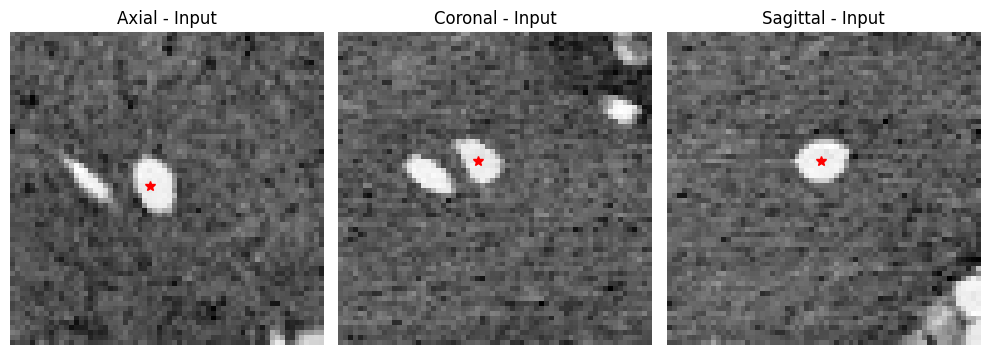

In [5]:
def display_prompt(point_prompt, mat):
    fig, axes = plt.subplots(1, 3, figsize=(10, 15))
    slice_titles = ["Axial", "Coronal", "Sagittal"]

    slices_input = [
        mat[point_prompt[0], :, :],  # Axial slice
        mat[:, point_prompt[1], :],  # Coronal slice
        mat[:, :, point_prompt[2]]  # Sagittal slice
    ]

    for i in range(3):
        axes[i].imshow(slices_input[i], cmap="gray")
        axes[i].set_title(f"{slice_titles[i]} - Input")
        axes[i].axis("off")

    # plot is y, x ordered
    axes[0].plot(point_prompt[2], point_prompt[1], marker='*', markersize=7, color="red")
    axes[1].plot(point_prompt[2], point_prompt[0] , marker='*', markersize=7, color="red")
    axes[2].plot(point_prompt[1], point_prompt[0], marker='*', markersize=7, color="red")

    plt.tight_layout()
    plt.show()
    
display_prompt(point_prompt, mat)

# Prediction
We simply predict on the volume using the given point prompt

In [6]:
# Predict on the full matrix with the point prompt
prediction = predictor.predict(mat, point_prompt)

tif.imwrite("predicted.tif", prediction)

propagate in video: 100%|██████████| 36/36 [00:30<00:00,  1.19it/s]


# Display
We display the 3D segmentation result by looking at the segmentation in the three orthogonal planes. 

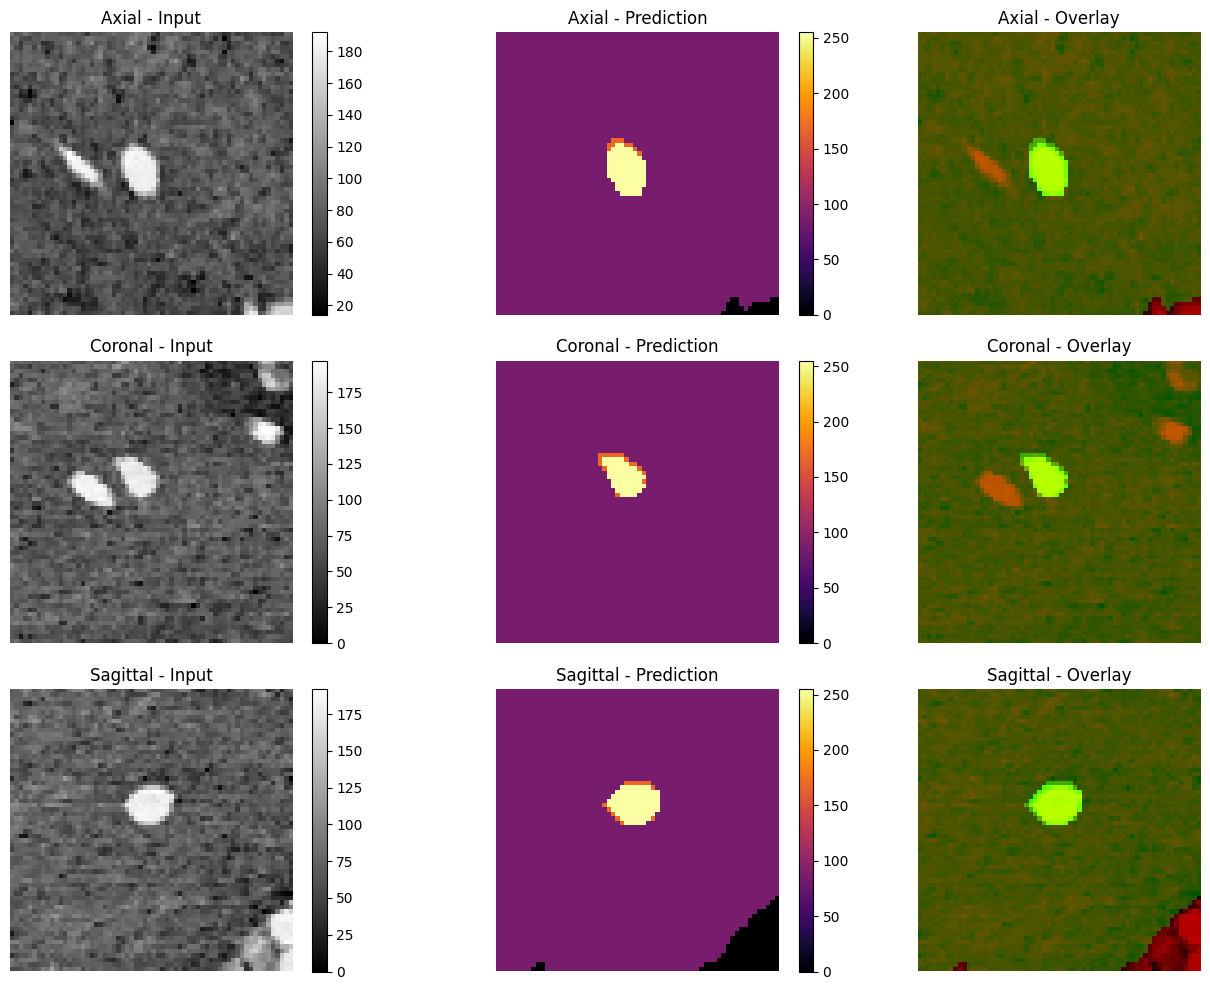

In [7]:
z, y, x = mat.shape
slice_idx = tuple(point_prompt)
axial_idx, coronal_idx, sagittal_idx = slice_idx

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
slice_titles = ["Axial", "Coronal", "Sagittal"]

slices_input = [
    mat[axial_idx, :, :],  # Axial slice
    mat[:, coronal_idx, :],  # Coronal slice
    mat[:, :, sagittal_idx]  # Sagittal slice
]

slices_prediction = [
    prediction[axial_idx, :, :],
    prediction[:, coronal_idx, :],
    prediction[:, :, sagittal_idx]
]

cmap = sns.color_palette("inferno", as_cmap=True)
norm = Normalize(vmin=np.min(prediction), vmax=np.max(prediction))

for i in range(3):
    im1 = axes[i, 0].imshow(slices_input[i], cmap='gray')
    axes[i, 0].set_title(f"{slice_titles[i]} - Input")
    axes[i, 0].axis("off")
    fig.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04)

    
    pred_im = axes[i, 1].imshow(slices_prediction[i], cmap=cmap, norm=norm)
    axes[i, 1].set_title(f"{slice_titles[i]} - Prediction")
    axes[i, 1].axis("off")
    fig.colorbar(pred_im, ax=axes[i, 1], fraction=0.046, pad=0.04)

    overlay = np.stack((slices_input[i], slices_prediction[i], np.zeros_like(slices_input[i])), axis=-1)  # RGB overlay
    axes[i, 2].imshow(overlay.astype(np.uint8))
    axes[i, 2].set_title(f"{slice_titles[i]} - Overlay")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Save prediction to view in external 3D viewer

In [8]:
tif.imwrite("prediction.tif", prediction)